In [ ]:
#@title Downloading dataset from GDrive
import gdown
import os

base_path = "Downloads/dataset"
os.makedirs(base_path, exist_ok=True)

link1 = "https://drive.google.com/uc?export=download&id=1TJy-nAS9L2xG3sSn0ZPK5MLaIib0yLHX"
link2 = "https://drive.google.com/uc?export=download&id=1f0VFieioGDig237kdHb-vDsSQ8IR7yCh"
link3 = "https://drive.google.com/uc?export=download&id=1nP3ACPxOClf0hGpw2iFHRZHg4aTLeKif"

path1 = os.path.join(base_path, "subtaskA_train_multilingual.jsonl") # Dev set
path2 = os.path.join(base_path, "subtaskA_dev_multilingual.jsonl") # Train set
path3 = os.path.join(base_path, "subtaskA_test_multilingual.jsonl")  # Test set(DO NOT TOUCH)

gdown.download(link1, path1, quiet=False)
gdown.download(link2, path2, quiet=False)
gdown.download(link3, path3, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1TJy-nAS9L2xG3sSn0ZPK5MLaIib0yLHX
From (redirected): https://drive.google.com/uc?export=download&id=1TJy-nAS9L2xG3sSn0ZPK5MLaIib0yLHX&confirm=t&uuid=5753bffa-b85a-40cd-9688-068c9873ffc3
To: /content/Downloads/dataset/subtaskA_train_multilingual.jsonl
100%|██████████| 587M/587M [00:05<00:00, 107MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1f0VFieioGDig237kdHb-vDsSQ8IR7yCh
To: /content/Downloads/dataset/subtaskA_dev_multilingual.jsonl
100%|██████████| 21.2M/21.2M [00:00<00:00, 52.3MB/s]
Downloading...
From (original): https://drive.google.com/uc?export=download&id=1nP3ACPxOClf0hGpw2iFHRZHg4aTLeKif
From (redirected): https://drive.google.com/uc?export=download&id=1nP3ACPxOClf0hGpw2iFHRZHg4aTLeKif&confirm=t&uuid=6b69c196-5f54-425e-a666-003e351fe064
To: /content/Downloads/dataset/subtaskA_test_multilingual.jsonl
100%|██████████| 117M/117M [00:01<00:00, 95.2MB/s]


'Downloads/dataset/subtaskA_test_multilingual.jsonl'

In [ ]:
#@title Installing dependencies
!pip install datasets evaluate accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.wh

In [ ]:
#@title Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Importing libraries
from datasets import Dataset
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import evaluate
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, AutoTokenizer, set_seed
import os
from sklearn.model_selection import train_test_split
from scipy.special import softmax
import argparse
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score,f1_score,ConfusionMatrixDisplay

In [ ]:
#@title Utility functions

def preprocess_function(examples, **fn_kwargs):
    return fn_kwargs['tokenizer'](examples["text"], truncation=True)


def get_data(train_path, test_path, random_seed):

    train_df = pd.read_json(train_path, lines=True)
    # test_df = pd.read_json(test_path, lines=True)

    train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=random_seed)

    return train_df, val_df

def compute_metrics(eval_pred):

    f1_metric = evaluate.load("f1")

    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    results = {}
    results.update(f1_metric.compute(predictions=predictions, references = labels, average="micro"))

    return results


def fine_tune(train_df, valid_df, checkpoints_path, id2label, label2id, model):

    train_dataset = Dataset.from_pandas(train_df)
    valid_dataset = Dataset.from_pandas(valid_df)

    tokenizer = AutoTokenizer.from_pretrained(model)
    model = AutoModelForSequenceClassification.from_pretrained(
       model, num_labels=len(label2id), id2label=id2label, label2id=label2id
    )

    tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True, fn_kwargs={'tokenizer': tokenizer})
    tokenized_valid_dataset = valid_dataset.map(preprocess_function, batched=True,  fn_kwargs={'tokenizer': tokenizer})


    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


    training_args = TrainingArguments(
        output_dir=checkpoints_path,
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=5,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train_dataset,
        eval_dataset=tokenized_valid_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    trainer.train()

    # saving best model
    best_model_path = checkpoints_path+'/best/'

    if not os.path.exists(best_model_path):
        os.makedirs(best_model_path)


    trainer.save_model(best_model_path)


def test(test_df, model_path, id2label, label2id):

    # load tokenizer from saved model
    tokenizer = AutoTokenizer.from_pretrained(model_path)

    model = AutoModelForSequenceClassification.from_pretrained(
       model_path, num_labels=len(label2id), id2label=id2label, label2id=label2id
    )

    test_dataset = Dataset.from_pandas(test_df)

    tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True,  fn_kwargs={'tokenizer': tokenizer})
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )
    predictions = trainer.predict(tokenized_test_dataset)
    prob_pred = softmax(predictions.predictions, axis=-1)
    preds = np.argmax(predictions.predictions, axis=-1)
    metric = evaluate.load("bstrai/classification_report")
    results = metric.compute(predictions=preds, references=predictions.label_ids)

    return results, preds


In [ ]:
#@title Merging train and dev for 2,3,4 and 5
train_df = pd.read_json(path1, lines=True)
print("_____SOURCE_____")
print(train_df["source"].value_counts())
print("_____MODEL_____")
print(train_df["model"].value_counts())
print(len(train_df))

dev_df = pd.read_json(path2, lines=True)
print("_____SOURCE_____")
print(dev_df["source"].value_counts())
print("_____MODEL_____")
print(dev_df["model"].value_counts())
print(len(dev_df))

train_df_merged = pd.concat([train_df,dev_df])
print(len(train_df_merged))

_____SOURCE_____
source
wikihow       30999
reddit        30999
arxiv         30997
wikipedia     29029
peerread      14565
bulgarian     12000
chinese       11934
indonesian     5995
urdu           5899
Name: count, dtype: int64
_____MODEL_____
model
human      83846
chatGPT    26208
davinci    20307
bloomz     14332
dolly      14046
cohere     13678
Name: count, dtype: int64
172417
_____SOURCE_____
source
russian    2000
arabic     1000
german     1000
Name: count, dtype: int64
_____MODEL_____
model
human      2000
chatGPT    1500
davinci     500
Name: count, dtype: int64
4000
176417


In [ ]:
source_dict={}
for source in train_df_merged.source.unique():
  if source in ("bulgarian","chinese","russian","wikihow","wikipedia","peerread","arxiv","reddit"):
    source_dict[source] = train_df_merged[train_df_merged.source == source]
print(source_dict.keys())

model_dict = {}
for source,df in source_dict.items():
  model_dict[f'{source}_0'] = df[df.model == "human"]
  model_dict[f'{source}_GPT'] = df[df.model == "chatGPT"]
  model_dict[f'{source}_davinci'] = df[df.model == "davinci"]
for k ,v in model_dict.items():
  print(f'{k} : {len(v)}')

dict_keys(['wikihow', 'wikipedia', 'reddit', 'arxiv', 'bulgarian', 'chinese', 'peerread', 'russian'])
wikihow_0 : 15999
wikihow_GPT : 3000
wikihow_davinci : 3000
wikipedia_0 : 14997
wikipedia_GPT : 2995
wikipedia_davinci : 3000
reddit_0 : 16000
reddit_GPT : 3000
reddit_davinci : 3000
arxiv_0 : 15998
arxiv_GPT : 3000
arxiv_davinci : 2999
bulgarian_0 : 6000
bulgarian_GPT : 3000
bulgarian_davinci : 3000
chinese_0 : 6000
chinese_GPT : 2970
chinese_davinci : 2964
peerread_0 : 2857
peerread_GPT : 2344
peerread_davinci : 2344
russian_0 : 1000
russian_GPT : 500
russian_davinci : 500


In [ ]:
#merged
#Creating train_data,val_data,test_data
first = model_dict["wikihow_0"]
train_df_70 = first[:int(0.7 * len(first))]
val_df_15 = first[int(0.7 * len(first)): int(0.85 * len(first))]
test_df_15 = first[int(0.85 * len(first)):]
for k , v in model_dict.items():
  if k == "wikihow_0":
    continue
  if "GPT" in k or "0" in k:
    slice_train= v[:int(0.7*len(v))]
    slice_val = v[int(0.7 * len(v)): int(0.85 * len(v))]
    slice_test= v[int(0.85 * len(v)):]
    train_df_70 = pd.concat([train_df_70,slice_train])
    val_df_15 = pd.concat([val_df_15,slice_val])
    test_df_15 = pd.concat([test_df_15,slice_test])
  else:
    test_df_15 = pd.concat([test_df_15,v])


print(train_df_70.source.value_counts())
print(len(train_df_70))
print(val_df_15.source.value_counts())
print(len(val_df_15))
print(test_df_15.source.value_counts())
print(len(test_df_15))
print(len(train_df_70)+len(val_df_15)+len(test_df_15))
print("--------------------------------------------------------")
print(train_df_70.model.value_counts())
print(len(train_df_70))
print(val_df_15.model.value_counts())
print(len(val_df_15))
print(test_df_15.model.value_counts())
print(len(test_df_15))
#train_data= train_df_70
#val_data = val_df_15
#test_data = test_df_10

source
reddit       13300
wikihow      13299
arxiv        13298
wikipedia    12593
bulgarian     6300
chinese       6279
peerread      3639
russian       1050
Name: count, dtype: int64
69758
source
wikihow      2850
reddit       2850
arxiv        2850
wikipedia    2699
bulgarian    1350
chinese      1345
peerread      781
russian       225
Name: count, dtype: int64
14950
source
wikihow      5850
reddit       5850
arxiv        5849
wikipedia    5700
bulgarian    4350
chinese      4310
peerread     3125
russian       725
Name: count, dtype: int64
35759
120467
--------------------------------------------------------
model
human      55193
chatGPT    14565
Name: count, dtype: int64
69758
model
human      11829
chatGPT     3121
Name: count, dtype: int64
14950
model
davinci    20807
human      11829
chatGPT     3123
Name: count, dtype: int64
35759


In [ ]:
#@title Training function


random_seed =0
train_path =  path1
dev_path =  path2
test_path = path3
model =  "xlm-roberta-base"
subtask =  'A'
prediction_path = os.path.join(base_path, "subtaskA_predictions.jsonl")

id2label = {0: "human", 1: "machine"}
label2id = {"human": 0, "machine": 1}

set_seed(random_seed)

train_df = train_df_70
val_df = val_df_15
# test_df = pd.read_json(test_path, lines=True)

# test_df = train_df[int(0.8*len(train_df)):]
# train_df= train_df[:int(0.8*len(train_df))]
# train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=random_seed)

print(len(train_df))
print(len(val_df))

#Fine tuning
fine_tune(train_df, val_df, f"{model}/subtask{subtask}/{random_seed}", id2label, label2id, model)
!zip -r Merge5_2e_5_5_16.zip "/content/xlm-roberta-base/subtaskA/0/best"
!cp Merge5_2e_5_5_16.zip /content/drive/MyDrive/


69758
14950


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/69758 [00:00<?, ? examples/s]

Map:   0%|          | 0/14950 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,F1
1,0.035400,0.661005,0.866355
2,0.022600,0.105220,0.980803


Epoch,Training Loss,Validation Loss,F1
1,0.035400,0.661005,0.866355
2,0.022600,0.105220,0.980803
3,0.005400,0.259533,0.961472
4,0.002700,0.128479,0.976321
5,0.002000,0.107550,0.984548


  adding: content/xlm-roberta-base/subtaskA/0/best/ (stored 0%)
  adding: content/xlm-roberta-base/subtaskA/0/best/config.json (deflated 51%)
  adding: content/xlm-roberta-base/subtaskA/0/best/model.safetensors (deflated 21%)
  adding: content/xlm-roberta-base/subtaskA/0/best/tokenizer_config.json (deflated 77%)
  adding: content/xlm-roberta-base/subtaskA/0/best/tokenizer.json (deflated 76%)
  adding: content/xlm-roberta-base/subtaskA/0/best/training_args.bin (deflated 51%)
  adding: content/xlm-roberta-base/subtaskA/0/best/sentencepiece.bpe.model (deflated 49%)
  adding: content/xlm-roberta-base/subtaskA/0/best/special_tokens_map.json (deflated 52%)


Mismatched label counts by source and model:
source     model    label
arxiv      davinci  1        2714
           human    0          51
bulgarian  chatGPT  1           3
           davinci  1          73
           human    0          58
chinese    davinci  1         199
           human    0          96
peerread   davinci  1           4
           human    0          23
reddit     chatGPT  1           1
           davinci  1          45
           human    0          44
russian    davinci  1          46
           human    0          14
wikihow    davinci  1         221
           human    0           2
wikipedia  davinci  1         200
           human    0          16
Name: count, dtype: int64
Accuracy: 0.8934533963477725
Precision: 0.9853338479351602
Recall: 0.8534893439197659
F1 Score: 0.9146849388687357


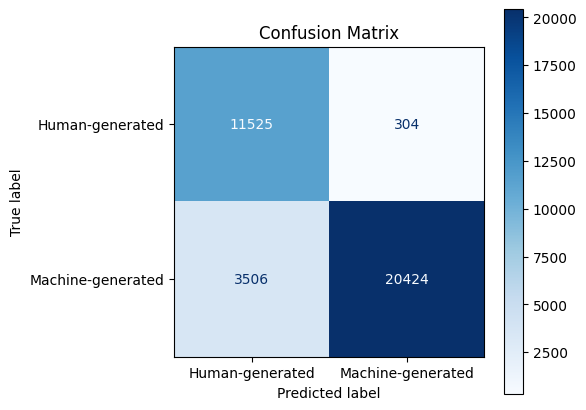

In [ ]:
#@title Testing on test_df_15

test_df = test_df_15
results, predictions = test(test_df, f"{model}/subtask{subtask}/{random_seed}/best/", id2label, label2id)

logging.info(results)
predictions_df = pd.DataFrame({'id': test_df['id'], 'label': predictions})
mask = test_df['label'] != predictions_df['label']
mismatched_df = test_df[mask]
# print(len(mismatched_df))
grouped_value_counts = mismatched_df.groupby(['source','model'])['label'].value_counts()
print("Mismatched label counts by source and model:")
print(grouped_value_counts)


accuracy = accuracy_score(test_df['label'], predictions_df['label'])
precision = precision_score(test_df['label'], predictions_df['label'], pos_label=1, average='binary')
recall = recall_score(test_df['label'], predictions_df['label'], pos_label=1, average='binary')
score = f1_score(test_df['label'], predictions_df['label'], pos_label=1, average='binary')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print(f"F1 Score: {score}")

cm = confusion_matrix(test_df['label'], predictions_df['label'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human-generated', 'Machine-generated'])
plt.figure(figsize=(5, 5))
disp.plot(values_format='d', cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix')
plt.show()